In [ ]:
# This calculate the absolute magnitude of Altair, so as to determine 
# absolute magnitudes of fake companions for making a contrast curve

# Created 2020 Feb. 27 by E.S.

# For the math, see research notebook fizeau_altair.tex on date 2020 Feb. 27

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib qt

### Set some constants

In [3]:
# distance of Altair
d_altair_pc = 5.13 # units pc (and plus/minus 0.015 pc)

# angular and physical radius of Altair
solar_radii_per_altair_radii = 1.65 # units of solar radii (ref: Table 1 in Monnier+ 2007)

m_per_au = 1.4959787066e11 # units meters
m_per_solar_radius = 6.95508e8 # units meters
au_per_pc = np.divide(360*60*60,2*np.pi) # units AU/pc

# distance of Altair in Altair radii (this should be about 1.4e8 altair radii)
d_altair_altair_radii = d_altair_pc*au_per_pc*np.divide(1.,m_per_solar_radius)*m_per_au*np.divide(1.,solar_radii_per_altair_radii)

# zero point on the Vega scale, specific to Paranal-NACO NB405 filter, from SVO filter service
# http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Paranal/NACO.NB405&&mode=browse&gname=Paranal&gname2=NACO#filter
zp_vega = 3.885e-12 # units erg /cm2 /sec /angstrom

##################################################################################################
# Surface flux of a model spectrum, based on a Kurucz model, courtesy SVO
# I tried to approximate parameters of Altair, which are 
# Teff=7550 K, logg=4.13, [Fe/H]=-0.24 \citep{erspamer2003automated}

## output from SVO:
# Kurucz ODFNEW /NOVER models
# teff = 7750 K (value for the effective temperature for the model. Temperatures are given in K)
# logg = 4.00 log(cm/s2) (value for Log(G) for the model.)
# meta = -0.5  (value for the Metallicity for the model.)
# lh = 1.25  (l/Hp where l is the  mixing length of the convective element and Hp is the pressure scale height)
# vtur = 2.0 km/s (Microturbulence velocity)
#
#                Filter #  Wavelength in Angstrom       #  Flux in erg/cm2/s/A
####################### #########################       ######################
#     Paranal/NACO.NB405           40555.445140895                 49610.952868

### ### IS THIS EVEN NEEDED? WE HAVE TO INTEGRATE OVER THE RESPONSE
model_flux_nb405 = 49610.952868 # units erg /cm2 /sec /angstrom 
# (note this is just a constant, implying spectrum is locally constant, which is fair given the narrowband filter)

### Read in filter curve

In [4]:
# NB405 filter

nb405_transmission = pd.read_csv("data/Paranal_NACO.NB405.dat.txt", 
                                 names=["wavel_angs", "transmission"], delim_whitespace=True)

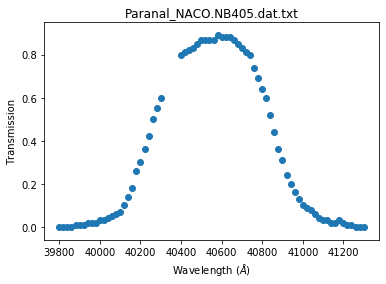

In [4]:
# plot filter

plt.clf()
plt.scatter(nb405_transmission["wavel_angs"],nb405_transmission["transmission"])
plt.title("Paranal_NACO.NB405.dat.txt")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Transmission")
plt.show()

### Read in model spectrum

In [5]:
# Kurucz ODFNEW /NOVER models
# teff = 7750 K (value for the effective temperature for the model. Temperatures are given in K)
# logg = 4.00 log(cm/s2) (value for Log(G) for the model.)
# meta = 0  (value for the Metallicity for the model.)
# lh = 1.25  (l/Hp where l is the  mixing length of the convective element and Hp is the pressure scale height)
# vtur = 2.0 km/s (Microturbulence velocity)
#
# column 1: WAVELENGTH (ANGSTROM), Wavelength in Angstrom
# column 2: FLUX (ERG/CM2/S/A), Flux in erg/cm2/s/A

model_spectrum = pd.read_csv("data/model_spec_teff_7750_logg_4_feh_0.txt",
                             names=["wavel_angs", "flux"], skiprows=9, delim_whitespace=True)

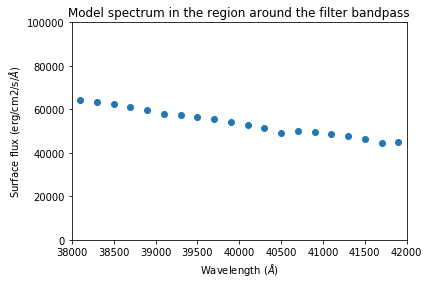

In [6]:
# plot spectrum

plt.clf()
plt.scatter(model_spectrum["wavel_angs"],model_spectrum["flux"])
plt.title("Model spectrum in the region around the filter bandpass")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Surface flux (erg/cm2/s/$\AA$)")
plt.ylim([0,1e5])
plt.xlim([38000,42000])
plt.show()

### The equation for relative magnitude of a star we want to solve is
### $m_{ \textrm{star}} = -2.5 \textrm{log}_{10} \left\{ \frac{\int d\lambda R_{\lambda}(\lambda) f_{\lambda}^{(0, star)}(\lambda) / \int d\lambda R_{\lambda}(\lambda) }{\textrm{zp}(f_{\lambda}^{(0, Vega)})}  \right\}$

### Step 1: Calculate inverse-square law scaling factor to convert surface flux $f_{\lambda}^{(surf, star)}(\lambda)$ to flux at top of Earth's atmosphere:
### $f_{\lambda}^{(0, star)}(\lambda) = \left( \frac{R_{star}}{D} \right)^{2} f_{\lambda}^{(surf, star)}(\lambda) $
### where the scaling factor is $\left( \frac{R_{star}}{D} \right)^{2}$

In [6]:
scale_factor = np.power(np.divide(1.,d_altair_altair_radii),2.)

#f0_star = scale_factor*model_flux_nb405 # units erg /cm2 /sec /angstrom

### Integration of star flux and filter response: 
### $\int d\lambda R_{\lambda}(\lambda) f_{\lambda}^{(0, star)}(\lambda) = \left( \frac{R_{star}}{D} \right)^{2}\int d\lambda R_{\lambda}(\lambda) f_{\lambda}^{(surf, star)}(\lambda) $

In [7]:
# To do the integration over two functions represented by input arrays, use the abcissa
# of the filter transmission $R$ to make an interpolated form of $f$ pinned to the same 
# ordinate. Then multiply the two arrays together and integrate over that.

model_surf_flux_filter_abcissa = np.interp(nb405_transmission["wavel_angs"].values, 
                                             model_spectrum["wavel_angs"].values,
                                             model_spectrum["flux"].values)

In [8]:
# now multiply the surface flux by the filter transmission to obtain the integrand

integrand_1 = np.multiply(nb405_transmission["transmission"],model_surf_flux_filter_abcissa)

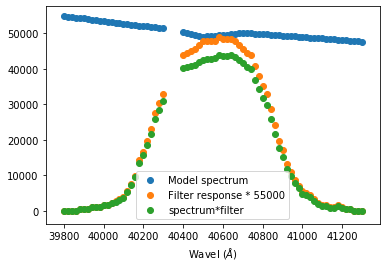

In [10]:
# plot everything so far

plt.clf()
plt.scatter(nb405_transmission["wavel_angs"],model_surf_flux_filter_abcissa,label="Model spectrum")
plt.scatter(nb405_transmission["wavel_angs"],55000*nb405_transmission["transmission"],label="Filter response * 55000")
plt.scatter(nb405_transmission["wavel_angs"],integrand_1,label="spectrum*filter")
plt.legend()
plt.xlabel("Wavel ($\AA$)")
#plt.ylabel("Surf flux or 55000*transmission")
plt.show()

In [9]:
# integrate 

integral_1 = np.trapz(integrand_1,x=nb405_transmission["wavel_angs"])

In [10]:
# multiply by inverse square law scaling factor

integral_2 = scale_factor*integral_1 # units erg /cm2 /sec /angstrom

### The normalization constant: 
### $\int d\lambda R_{\lambda}(\lambda) $

In [11]:
integral_3 = np.trapz(nb405_transmission["transmission"],x=nb405_transmission["wavel_angs"])

### Put everything together to get an apparent magnitude. Reiterating, we want
### $m_{ \textrm{star}} = -2.5 \textrm{log}_{10} \left\{ \frac{\int d\lambda R_{\lambda}(\lambda) f_{\lambda}^{(0, star)}(\lambda) / \int d\lambda R_{\lambda}(\lambda) }{\textrm{zp}(f_{\lambda}^{(0, Vega)})}  \right\}$

In [12]:
### call these
### m_rel_star = -2.5 * np.log10( np.divide(integral_2 / integral_3), zp_vega)

In [13]:
m_rel_star = -2.5 * np.log10( np.divide( np.divide(integral_2,integral_3), zp_vega) )

### Get absolute magnitude via the distance modulus:
### $M_{\textrm{star}}=m_{\textrm{star}}-5\textrm{log}_{10}\left( \frac{d}{10 \textrm{pc}} \right)$

In [14]:
M_abs_star = m_rel_star - 5*np.log10(np.divide(d_altair_pc,10.))

In [15]:
M_abs_star

1.8729857760567394

### Consider atmospheric transmission effects

In [16]:
# For considering airmass and PWV transmission effects, here are plots of transmission

# source: https://atran.arc.nasa.gov/cgi-bin/atran/atran.cgi

# INPUT PARAMS for atran.plt.12172.dat:
'''
Altitude    :    10567.0000    
 Water Vapor :    11.0000000    
 Num layers  :            2
 Zenith Angle:    30.0000000    
 Obs Lat     :    30.0000000    
 Minimum Wave:    3.98000002    
 Maximum Wave:    4.13000011   
'''

trans_df = pd.read_csv("data/atran.plt.12172.dat", usecols=[1,2], 
                       names=["wavel_um","transmission"], delim_whitespace=True)

In [17]:
# Read in blackbodies in the general range of relevant temperatures of planets
# (see research journal, 2020 Mar. 4)

bb_00200K = pd.read_csv("data/bb00200.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)
bb_00400K = pd.read_csv("data/bb00400.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)
bb_00650K = pd.read_csv("data/bb00650.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)
bb_02800K = pd.read_csv("data/bb02800.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)

In [23]:
np.divide(bb_00200K["flux"],np.max(bb_00200K["flux"]))*55000

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1009    0.078717
1010    0.075674
1011    0.072748
1012    0.069936
1013    0.067231
Name: flux, Length: 1014, dtype: float64

In [21]:
# plot everything for comparison: stellar spectrum, planet spectra, filter 
# and atmospheric transmission

plt.clf()
plt.scatter(trans_df["wavel_um"],55000*trans_df["transmission"],s=2,label="55000* Atm. trans.")
plt.plot((1e-4)*model_spectrum["wavel_angs"],model_spectrum["flux"],color="orange",label="Model Altair spectrum")
plt.plot((1e-4)*bb_00200K["wavel_angs"],np.divide(bb_00200K["flux"],np.max(bb_00200K["flux"]))*55000,
         label="BB, T=200K")
plt.plot((1e-4)*bb_00400K["wavel_angs"],np.divide(bb_00400K["flux"],np.max(bb_00400K["flux"]))*55000,
         label="BB, T=400K")
plt.plot((1e-4)*bb_00650K["wavel_angs"],np.divide(bb_00650K["flux"],np.max(bb_00650K["flux"]))*55000,
         label="BB, T=650K")
plt.plot((1e-4)*bb_02800K["wavel_angs"],np.divide(bb_02800K["flux"],np.max(bb_02800K["flux"]))*55000,
         label="BB, T=2800K")
plt.scatter((1e-4)*nb405_transmission["wavel_angs"],55000*nb405_transmission["transmission"],s=2,
            label="55000*NB405 trans.")
plt.title("Comparison of filter profile, stellar spectrum, and atmospheric transmission\n"+
          "Altitude: 10567 ft; Obs Lat: 30 deg; Water Vapor: 11 um; Zenith angle: 30 deg")
plt.xlabel("Wavelength (um)")
plt.ylabel("Transmission")
plt.xlim([np.min(trans_df["wavel_um"]),np.max(trans_df["wavel_um"])])
plt.ylim([0,6e4])
plt.legend()
plt.show()

In [36]:
np.median(model_spectrum["flux"])

1874730.0

In [38]:
np.max(trans_df["wavel_um"])

4.12999439

In [40]:
plt.plot((1e-4)*model_spectrum["wavel_angs"],model_spectrum["flux"])
plt.show()

In [1]:
# plot BBs only

plt.clf()
plt.plot((1e-4)*bb_00200K["wavel_angs"],np.divide(bb_00200K["flux"],np.max(bb_00200K["flux"])),label="BB, 200K")
plt.plot((1e-4)*bb_00400K["wavel_angs"],np.divide(bb_00400K["flux"],np.max(bb_00400K["flux"])),label="BB, 400K")
plt.plot((1e-4)*bb_00650K["wavel_angs"],np.divide(bb_00650K["flux"],np.max(bb_00650K["flux"])),label="BB, 650K")
plt.plot((1e-4)*bb_02800K["wavel_angs"],np.divide(bb_02800K["flux"],np.max(bb_02800K["flux"])),label="BB, 2800K")
plt.axvline(x=4.02, linestyle=":")
plt.axvline(x=4.08, linestyle=":")
plt.xlim([0,40])
plt.xlabel("Wavelength (um)")
plt.ylabel("Emission")
plt.title("Normalized BB emission based on re-emitted redistributed incident energy")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [28]:
plt.clf()
plt.plot((1e-4)*bb_00200K["wavel_angs"],bb_00200K["flux"],label="BB, 200K")
plt.plot((1e-4)*bb_00400K["wavel_angs"],bb_00400K["flux"],label="BB, 400K")
plt.plot((1e-4)*bb_00650K["wavel_angs"],bb_00650K["flux"],label="BB, 650K")
plt.axvline(x=4.02, linestyle=":")
plt.axvline(x=4.08, linestyle=":")
plt.xlim([0,40])
plt.xlabel("Wavelength (um)")
plt.ylabel("Emission")
plt.title("Normalized BB emission based on re-emitted redistributed incident energy")
plt.legend()
plt.show()